# Importación de librerías y datos

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

Revisamos que la GPU esté disponible

In [2]:
use_cuda = torch.cuda.is_available()
print("Using CUDA: {}".format(use_cuda))

Using CUDA: True


Cargamos los datos desde `data/rating.csv`

In [3]:
data_df = pd.read_csv("data/ratings.csv")

data_df.sample(10)

,userId,movieId,rating,timestamp
51911,337,50,3.0,860256158
88754,573,1527,4.5,1248842035
20872,138,1019,5.0,1222676090
51251,331,6534,0.5,1537158378
97686,606,1958,4.0,1171377019
21296,140,2085,4.0,1021899051
14946,95,2600,2.5,1105401161
6792,45,3617,4.0,1007995150
32541,221,7361,4.0,1111178504
11172,68,8529,2.5,1158533300


Exploramos brevemente los datos

In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
data_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [6]:
missing_values = data_df.isnull().any().any()
print("Missing values exist: {}".format(missing_values))

Missing values exist: False


# 1. Análisis inicial de datos

Analizar el dataset para utilizar solamente las 200 películas con mayor cantidad de votos y los usuarios que hayan votado al menos 100 películas.

In [7]:
movie_vote_counts = data_df.groupby('movieId').size().sort_values(ascending=False)
top_200_movies = movie_vote_counts.head(200).index

filtered_data = data_df[data_df['movieId'].isin(top_200_movies)]

In [8]:
user_vote_counts = filtered_data.groupby('userId').size()
active_users = user_vote_counts[user_vote_counts >= 100].index

filtered_data = filtered_data[filtered_data['userId'].isin(active_users)]

In [9]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8329 entries, 1772 to 100452
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     8329 non-null   int64  
 1   movieId    8329 non-null   int64  
 2   rating     8329 non-null   float64
 3   timestamp  8329 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 325.4 KB


In [10]:
x = filtered_data.drop(['userId', 'movieId', 'rating'], axis=1)
y = filtered_data['rating']

In [11]:
x = x.to_numpy()
y = y.to_numpy()

# Normalize the data
scaler = MinMaxScaler()
x_norm = scaler.fit_transform(x)

In [12]:
idx = np.random.permutation(len(x_norm))
train_idx = idx[:int(0.85 * len(x_norm))]
valid_idx = idx[int(0.85 * len(x_norm)):]
                
train_x = x_norm[train_idx]
train_y = y[train_idx]
valid_x = x_norm[valid_idx]
valid_y = y[valid_idx]

n_train = len(train_x)
n_valid = len(valid_x)

In [13]:
user_id = filtered_data['userId']
movie_id = filtered_data['movieId']

In [14]:
user_id_to_idx = {value: idx for idx, value in enumerate(user_id.unique())}
movie_id_to_idx = {value: idx for idx, value in enumerate(movie_id.unique())}

In [15]:
user_idx = np.array([user_id_to_idx[value] for value in user_id])
movie_idx = np.array([movie_id_to_idx[value] for value in movie_id])

In [16]:
user_idx_train = user_idx[train_idx]
movie_idx_train = movie_idx[train_idx]

user_idx_valid = user_idx[valid_idx]
movie_idx_valid = movie_idx[valid_idx]

In [17]:
class MyDataset(Dataset):
    def __init__(self, x, user_id_idx, movie_id_idx, y):
        self.x = x
        self.user_id_idx = user_id_idx
        self.movie_id_idx = movie_id_idx
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.user_id_idx[idx], self.movie_id_idx[idx], self.y[idx]

In [18]:
train_dataset = MyDataset(train_x, user_idx_train, movie_idx_train, train_y)
valid_dataset = MyDataset(valid_x, user_idx_valid, movie_idx_valid, valid_y)

In [19]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

# 2. Construcción de la red neuronal

A partir del dataset del punto 1, construir una única red neuronal que utilice una capa de embeddings para el id de usuario, una capa de embeddings para el id de película y al menos dos capas lineales que sea capaz de predecir el puntaje que cada usuario colocó a cada pelicula. Usar tecnicas de normalizacion en caso de ser necesario.

In [20]:
class NNet(torch.nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim=8):
        super(NNet, self).__init__()
        self.user_embedding = torch.nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = torch.nn.Embedding(num_movies, embedding_dim)
        self.fc1 = torch.nn.Linear(1 + embedding_dim*2, 128, bias=True)
        self.dropout_1 = torch.nn.Dropout(0.4)
        self.fc2 = torch.nn.Linear(128, 64, bias=True)
        self.dropout_2 = torch.nn.Dropout(0.3)
        self.fc3 = torch.nn.Linear(64, 1, bias=True)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x, user_ids, movie_ids):
        user_embeds = self.user_embedding(user_ids)
        movie_embeds = self.movie_embedding(movie_ids)
        x = torch.cat([x, user_embeds, movie_embeds], dim=1)
        x = self.relu(self.fc1(x))
        x = self.dropout_1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout_2(x)
        x = self.fc3(x)
        x = self.sigmoid(x) * 5
        return x

In [31]:
num_users = len(filtered_data['userId'].unique())
num_movies = len(filtered_data['movieId'].unique())
model = NNet(num_users, num_movies)

if use_cuda:
    model = model.to('cuda')

In [32]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [33]:
epochs = 250

train_losses_by_epoch = []
valid_losses_by_epoch = []
train_mse_by_epoch = []
valid_mse_by_epoch = []

for epoch in range(epochs):
    
    model.train()
    
    epoch_loss = 0
    epoch_y_hat = []
    epoch_y = []
    
    for idx, data in enumerate(train_loader):
        x_batch, user_id_batch, movie_id_batch, y_batch = data
        
        if use_cuda:
            x_batch = x_batch.to('cuda').float()
            user_id_batch = user_id_batch.to('cuda').int()
            movie_id_batch = movie_id_batch.to('cuda').int()
            y_batch = y_batch.to('cuda').reshape(-1, 1).float()
        
        optimizer.zero_grad()
        
        y_batch_hat = model(x_batch, user_id_batch, movie_id_batch)
        
        loss = loss_fn(y_batch_hat, y_batch)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_y.extend(y_batch.detach().cpu().numpy())
        epoch_y_hat.extend(y_batch_hat.detach().cpu().numpy())        
        
        epoch_loss += loss.item()
        
    epoch_loss /= n_train
    
    train_losses_by_epoch.append(epoch_loss)
    
    train_mse = metrics.mean_squared_error(epoch_y, epoch_y_hat)
    train_mse_by_epoch.append(train_mse)
        
    model.eval()
    
    valid_epoch_loss = 0
    
    valid_epoch_y_hat = []
    valid_epoch_y = []
    
    with torch.no_grad():
        for idx, data in enumerate(valid_loader):
            x_batch, user_id_batch, movie_id_batch, y_batch = data
            
            if use_cuda:
                x_batch = x_batch.cuda().float()
                user_id_batch = user_id_batch.cuda().int()
                movie_id_batch = movie_id_batch.cuda().int()
                y_batch = y_batch.cuda().reshape(-1, 1).float()
            
            y_batch_hat = model(x_batch, user_id_batch, movie_id_batch)
            
            loss = loss_fn(y_batch_hat, y_batch)
            
            valid_epoch_y.extend(y_batch.detach().cpu().numpy())
            valid_epoch_y_hat.extend(y_batch_hat.detach().cpu().numpy())
            
            valid_epoch_loss += loss.item()
    
    valid_epoch_loss /= n_valid
    
    valid_losses_by_epoch.append(valid_epoch_loss)
    
    valid_mse = metrics.mean_squared_error(valid_epoch_y, valid_epoch_y_hat)
    valid_mse_by_epoch.append(valid_mse)
    
    print("Epoch: {}, Train Loss: {:.4f}, Train MSE: {:.4f}, Valid Loss: {:.4f}, Valid MSE: {:.4f}".format(epoch, epoch_loss, train_mse, valid_epoch_loss, valid_mse))

Epoch: 0, Train Loss: 0.0263, Train MSE: 1.6800, Valid Loss: 0.0168, Valid MSE: 1.0543
Epoch: 1, Train Loss: 0.0147, Train MSE: 0.9403, Valid Loss: 0.0128, Valid MSE: 0.8043
Epoch: 2, Train Loss: 0.0136, Train MSE: 0.8666, Valid Loss: 0.0125, Valid MSE: 0.7850
Epoch: 3, Train Loss: 0.0133, Train MSE: 0.8484, Valid Loss: 0.0123, Valid MSE: 0.7731
Epoch: 4, Train Loss: 0.0131, Train MSE: 0.8366, Valid Loss: 0.0122, Valid MSE: 0.7645
Epoch: 5, Train Loss: 0.0130, Train MSE: 0.8268, Valid Loss: 0.0121, Valid MSE: 0.7587
Epoch: 6, Train Loss: 0.0129, Train MSE: 0.8202, Valid Loss: 0.0120, Valid MSE: 0.7538
Epoch: 7, Train Loss: 0.0127, Train MSE: 0.8100, Valid Loss: 0.0120, Valid MSE: 0.7503
Epoch: 8, Train Loss: 0.0127, Train MSE: 0.8090, Valid Loss: 0.0119, Valid MSE: 0.7469
Epoch: 9, Train Loss: 0.0127, Train MSE: 0.8091, Valid Loss: 0.0119, Valid MSE: 0.7452
Epoch: 10, Train Loss: 0.0126, Train MSE: 0.8017, Valid Loss: 0.0119, Valid MSE: 0.7416
Epoch: 11, Train Loss: 0.0125, Train MSE: 

# 3. Gráficas de entrenamiento y validación

/tmp/ipykernel_1280/1673019763.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


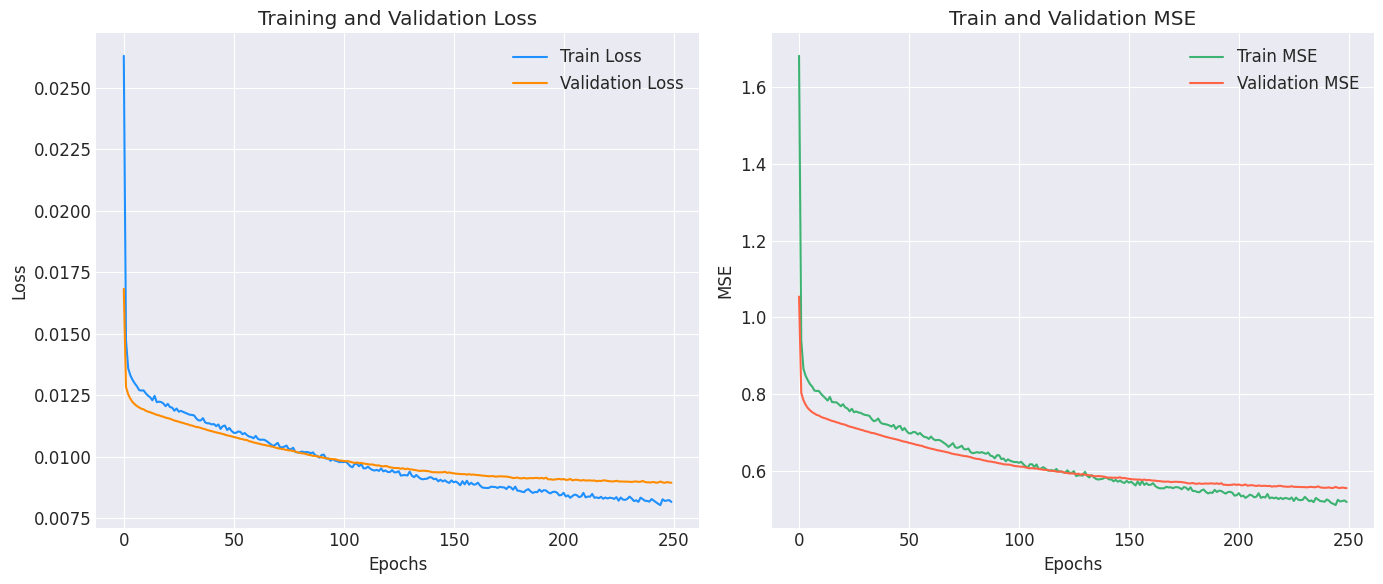

In [37]:
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 12})

train_loss_color = 'dodgerblue'
valid_loss_color = 'darkorange'
train_mse_color = 'mediumseagreen'
valid_mse_color = 'tomato'

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses_by_epoch, label='Train Loss', color=train_loss_color)
plt.plot(valid_losses_by_epoch, label='Validation Loss', color=valid_loss_color)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_mse_by_epoch, label='Train MSE', color=train_mse_color)
plt.plot(valid_mse_by_epoch, label='Validation MSE', color=valid_mse_color)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Train and Validation MSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [36]:
# Save the model
torch.save(model.state_dict(), f'models/model_loss_{valid_epoch_loss:.4f}_mse_{valid_mse:.4f}_train_loss_{epoch_loss:.4f}_mse_{train_mse:.4f}.pth')

# 4. Predicciones

Construir una funcion capaz de recibir un usuario al azar, una cantidad "p" de películas que dicho usuario haya puntuado y verificar la predicción del modelo. Comparar con los puntajes reales contra los que el usuario asignó a dicha/s película/s

In [47]:
model = model.to('cpu')

In [74]:
import random 

def verificar_prediccion(user_id, p, model, data, scaler):
    # Obtener las p películas más recientes del usuario
    p_movies = data[data['userId'] == user_id].sample(n=p)

    x = torch.tensor(p_movies['timestamp'].values, dtype=torch.float)
    user_ids = torch.tensor(p_movies['userId'].values, dtype=torch.long)
    movies_ids = torch.tensor(p_movies['movieId'].values, dtype=torch.long)
    true_ratings = p_movies['rating'].values
    
    print(x[0], user_ids[0], movies_ids[0])

    pred_ratings = model(x[0], user_ids[0], movies_ids[0])
    #     calificaciones_predichas = scaler.inverse_transform(calificaciones_predichas.reshape(-1, 1)).flatten()

    # for idx, row in usuario_peliculas.iterrows():
    #     print(f"Película ID: {row['movieId']}, Calificación Real: {row['rating']}, Calificación Predicha: {calificaciones_predichas[idx]}")


In [81]:
user_id.sample(10)

45968    305
51160    330
36418    249
67961    438
69403    448
9431      64
57405    380
54222    357
23925    166
10441     68
Name: userId, dtype: int64

In [93]:
x = torch.tensor([[1.4570e+09]])
user_ids = torch.tensor([18])
movie_id = torch.tensor([0])

model(x, user_ids, movie_id)

tensor([[5.]], grad_fn=<MulBackward0>)

In [86]:
output

tensor([[5.]], grad_fn=<MulBackward0>)

In [75]:
verificar_prediccion(18, 5, model, filtered_data, scaler)

tensor(1.4570e+09) tensor(18) tensor(4011)


IndexError: index out of range in self